# [E-08] 뉴스 요약봇 만들기
이번 프로젝트는 텍스트 요약을 구현하는 추상/추출 접근법을 알아보고, Attentional seq2seq 구조를 활용하여 뉴스 기사를 요약하는 모델을 구현해 보는 것을 목표로 한다.

<hr>

## **1. 데이터 준비**

### 라이브러리 불러오기

In [ ]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import tensorflow as tf
import os, re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
resolver=tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.77.43.218:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.77.43.218:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


### 데이터 불러오기

In [ ]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")

('news_summary_more.csv', <http.client.HTTPMessage at 0x7fee27146b10>)

In [ ]:
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [ ]:
data.sample(10)

,headlines,text
5699,Worse than school kids: Lok Sabha Speaker Sumi...,Lok Sabha Speaker Sumitra Mahajan on Tuesday a...
20708,India to get its own astronaut training facili...,After PM Narendra Modi announced India's first...
64637,Nawaz Sharif planned to murder me twice: Ex-Pa...,Pakistan's ex-President Asif Zardari has claim...
18297,IIT Bombay announces its business model compet...,IIT Bombay's Entrepreneurship Cell has announc...
80270,Luck stronger factor than talent to be an acto...,Veteran actor Shakti Kapoor has said luck is a...
60616,ISIS poster threatens Christmas attack on the ...,A propaganda poster released by pro-ISIS Wafa ...
59162,Former SpaceX intern claims Musk is the Founde...,"Former SpaceX intern, Sahil Gupta, has claimed..."
71827,Constant US threats boosted N Korea's missile ...,Constant threats made by the US against North ...
11838,CBI was planning to arrest Asthana before HC o...,A CBI team was planning to arrest the agency's...
53965,Bihar CM Nitish Kumar's son four times richer ...,According to details uploaded on Bihar governm...


데이터를 확인해보면 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어 있다.



<hr>

## **2. 데이터 전처리**

### 데이터 정리

In [ ]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


### 중복값 제거

In [ ]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 결측치 제거

In [ ]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 텍스트 정규화

In [ ]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


### 불용어 제거

In [ ]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [ ]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [ ]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않음

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


In [ ]:
clean_text = []
# 전체 Text 데이터에 대한 전처리
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [ ]:
clean_headlines = []
# 전체 Text 데이터에 대한 전처리 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

# 전처리 후 출력
print("Headline 전처리 후 결과: ", clean_headlines[:5])

Headline 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [ ]:
data['text'] = clean_text
data['headlines'] = clean_headlines

data.head()

,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...


In [ ]:
# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 최대길이 지정

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


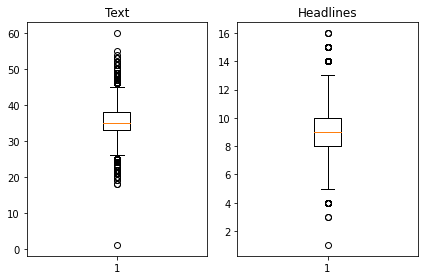

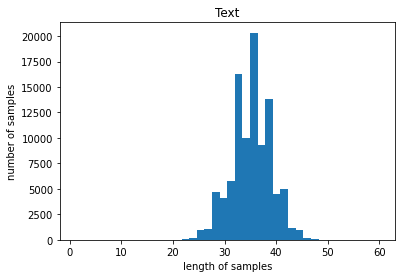

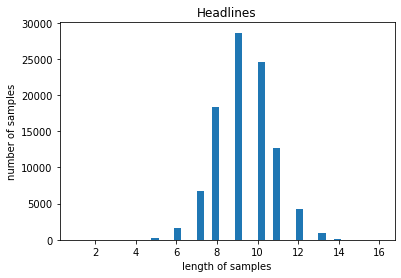

In [ ]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
head_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(head_len)))
print('요약의 최대 길이 : {}'.format(np.max(head_len)))
print('요약의 평균 길이 : {}'.format(np.mean(head_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(head_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(head_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
text_max_len = 40
headlines_max_len = 12

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [ ]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 89775


### 데이터 토큰화

In [ ]:
data["decoder_input"] = data["headlines"].apply(lambda x: "sostoken " + x)
data["decoder_target"] = data["headlines"].apply(lambda x: x + " eostoken")
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


In [ ]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 데이터셋 분리

훈련 데이터와 테스트 데이터를 8:2로 나누어주었다.

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)


[59569 70197 20507 ... 54953 12686 70243]


In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17955


In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 71820
훈련 레이블의 개수 : 71820
테스트 데이터의 개수 : 17955
테스트 레이블의 개수 : 17955


### 단어 집합(vocabulary) 만들기

In [ ]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [ ]:
threshold = 8
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받음
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 65622
등장 빈도가 7번 이하인 희귀 단어의 수: 46093
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19529
단어 집합에서 희귀 단어의 비율: 70.24016335984882
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.058221608578397


희귀 단어를 제외한 단어 집합의 크기는 19517개이므로 19000개로 단어 집합의 크기를 제한한다.

In [ ]:
src_vocab = 19000 
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 19,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train[:1])

[[9797, 3714, 40, 4103, 1720, 154, 56, 3105, 10273, 2959, 134, 2013, 8284, 942, 81, 7505, 358, 786, 1554, 121, 29, 39, 767, 13901, 2960, 13405, 4562, 360, 11094, 78, 142, 40, 17347, 10819, 626, 245]]


In [ ]:
# decoder 데이터도 동일하게 진행

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

threshold = 8
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받음
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28723
등장 빈도가 7번 이하인 희귀 단어의 수: 20362
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8361
단어 집합에서 희귀 단어의 비율: 70.89092365003656
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.275678942757604


In [ ]:
tar_vocab = 8000

tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

print("input ", decoder_input_train[:5])
print("decoder ", decoder_target_train[:5])

input  [[1, 138, 4, 1840, 69, 7737, 624, 12, 5550], [1, 518, 1257, 253, 3963, 801, 3, 163, 25, 3, 153, 429], [1, 6137, 80, 6856, 7, 2393, 1714, 6, 576, 149], [1, 116, 3850, 5333, 49, 7, 230, 802], [1, 1344, 6, 279, 1583, 4, 2880, 151, 85]]
decoder  [[138, 4, 1840, 69, 7737, 624, 12, 5550, 2], [518, 1257, 253, 3963, 801, 3, 163, 25, 3, 153, 429, 2], [6137, 80, 6856, 7, 2393, 1714, 6, 576, 149, 2], [116, 3850, 5333, 49, 7, 230, 802, 2], [1344, 6, 279, 1583, 4, 2880, 151, 85, 2]]


In [ ]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 71819
훈련 레이블의 개수 : 71819
테스트 데이터의 개수 : 17955
테스트 레이블의 개수 : 17955


### 패딩(padding)하기

In [ ]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

<hr>

## **3. 모델 설계**

### 인코더 모델 설계

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256 

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, 
                     return_sequences=True, 
                     return_state=True ,
                     dropout = 0.4, 
                     recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, 
                     return_sequences=True, 
                     return_state=True, 
                     dropout=0.4, 
                     recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, 
                     return_state=True, 
                     return_sequences=True, 
                     dropout=0.4, 
                     recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### 디코더 모델 설계

In [ ]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, 
                    return_sequences=True, 
                    return_state=True, 
                    dropout=0.4, 
                    recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      2432000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 40, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

### 어텐션 메커니즘(Attention Mechanism)

In [ ]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      2432000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 40, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

<hr>

## **4. 모델 훈련**

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
es = EarlyStopping(monitor="val_loss", patience=2, verbose=1)

history = model.fit(
    x=[encoder_input_train, decoder_input_train],
    y=decoder_target_train,
    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
    batch_size=256,
    callbacks=[es],
    epochs=50,
)

In [ ]:
# 위 과정을 한 번에

embedding_dim = 128
hidden_size = 256 
batch_size = 256
epochs = 50

with strategy.scope():
  encoder_inputs = Input(shape=(text_max_len,))
  enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)
  encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
  encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
  encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
  encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
  encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
  encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

  decoder_inputs = Input(shape=(None,))
  dec_emb_layer = Embedding(tar_vocab, embedding_dim)
  dec_emb = dec_emb_layer(decoder_inputs)
  decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
  decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
  decoder_softmax_layer = Dense(tar_vocab, activation='softmax')  
  decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 
  model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)

  from tensorflow.keras.layers import AdditiveAttention
  attn_layer = AdditiveAttention(name='attention_layer')
  attn_out = attn_layer([decoder_outputs, encoder_outputs])
  decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
  decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
  decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)
  model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)

  model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
  es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
  history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
            validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
            batch_size=batch_size, callbacks=[es], epochs=epochs)

Epoch 1/50
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


281/281 [==============================] - 54s 111ms/step - loss: 5.4482 - val_loss: 5.0510
Epoch 2/50
281/281 [==============================] - 15s 54ms/step - loss: 4.9110 - val_loss: 4.6759
Epoch 3/50
281/281 [==============================] - 15s 53ms/step - loss: 4.5610 - val_loss: 4.3997
Epoch 4/50
281/281 [==============================] - 15s 52ms/step - loss: 4.3002 - val_loss: 4.2300
Epoch 5/50
281/281 [==============================] - 15s 53ms/step - loss: 4.1078 - val_loss: 4.1000
Epoch 6/50
281/281 [==============================] - 15s 53ms/step - loss: 3.9505 - val_loss: 3.9926
Epoch 7/50
281/281 [==============================] - 15s 53ms/step - loss: 3.8119 - val_loss: 3.9110
Epoch 8/50
281/281 [==============================] - 15s 53ms/step - loss: 3.6900 - val_loss: 3.8358
Epoch 9/50
281/281 [==============================] - 15s 54ms/step - loss: 3.5798 - val_loss: 3.7842
Epoch 10/50
281/281 [==============================] - 15s 53ms/step - loss: 3.4840 - val_lo

### loss 시각화

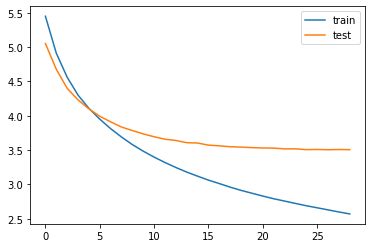

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

<hr>

## **5. 인퍼런스 모델 구현**

인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 작동해야 하기 때문에 인퍼런스를 위한 모델 설계가 별도로 필요하다.

정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해주어야 하기 때문에 다음과 같이 3개의 사전을 준비해준다.

In [ ]:
# 원문 단어 집합에서 정수 -> 단어를 얻음
src_index_to_word = src_tokenizer.index_word 

# 요약 단어 집합에서 단어 -> 정수를 얻음
tar_word_to_index = tar_tokenizer.word_index 

# 요약 단어 집합에서 정수 -> 단어를 얻음
tar_index_to_word = tar_tokenizer.index_word 

인코더와 디코더의 모델은 분리해서 설계한다.

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들어준다.

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

결과를 편하게 확인하기 위해 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수도 만들어준다.

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

테스트 데이터 10개의 샘플에 대해서 실제 헤드라인과 예측된 헤드라인을 비교해본다.

In [ ]:
for i in range(10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 헤드라인 :", seq2summary(decoder_input_test[i]))
    print("예측 헤드라인 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : uk end free movement labour immediately brexit make mandatory eu nationals show passport enter country according leaked post brexit immigration system plans plans also propose temporary biometric residence permits system eu nationals coming uk months 
실제 헤드라인 : eu nationals to passport to enter uk leaked docs 
예측 헤드라인 :  uk to move to uk citizens to avoid brexit


원문 : microsoft owned linkedin thursday announced hired mahesh narayanan country manager india assume new role january professional networking platform said narayanan harvard university alumnus previously worked india managing director music streaming platform google india head mobile ads business 
실제 헤드라인 : linkedin hires former google india exec as country manager 
예측 헤드라인 :  microsoft india to be named as indian president


원문 : former flipkart ceo co founder sachin bansal planning launch venture capital fund million billion investing startups end reports said sachin made billion leaving flipkart reportedly contribute 

예측 헤드라인을 확인해 본 결과, 실제 헤드라인과는 차이가 있으나 어느 정도 원문과 연관성이 보이는 문장들이었다.

<hr>

## **6. 추출적 요약**

In [ ]:
!pip install summa

     |████████████████████████████████| 54 kB 1.9 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54412 sha256=76cb255f7c33fb50ddd4c1653c36c28ce590e772e345c08dd15764ef6c199b72
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
Successfully built summa


In [ ]:
import requests
import urllib.request
from summa.summarizer import summarize

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [ ]:
for i in range(5):
    print("원문 : \n ", data['text'][i])
    print("실제 요약 : \n ", data['headlines'][i])
    print("예측 요약 : \n ", summarize(data['text'][i], ratio=0.4))
    print("\n")

원문 : 
  Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : 
  upGrad learner switches to career in ML & Al with 90% salary hike
예측 요약 : 
  upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : 
  Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : 
  Delhi techie wins free food from Swiggy for one year on CRED
예측 요약 : 
  Users get one CRED coin per

# **프로젝트 회고**

기존에 진행했었던 자연어 처리 프로젝트들보다 난이도가 많이 높아진 느낌이었다. 뉴스 기사를 요약하는 모델을 만들기 위해 Attentional seq2seq를 이용한 추상적 요약과 summa.summarizer를 사용한 추출적 요약을 해보았다. 두 가지 방식으로 나온 요약의 결과물은 실제 기사의 헤드라인과 비교하였다. 공통적으로 두 요약 모두 대부분의 결과물이 원문의 핵심 단어들을 포함하고 있었다. 하지만 두 요약에서의 차이점도 확연히 구분되었다.

먼저 추상적 요약은 원문에 없던 내용을 만들어 새로운 문장을 생성해내는 것이다. 원문에는 존재하지 않는 단어들을 사용하기도 하기 때문에 관련이 없는 단어들을 사용하기도 했다. 모델을 훈련시키는데 많은 시간이 소요되었다. early stopping을 통해 얻은 validation loss는 3.51로 잘 훈련되었다고 판단할 수 있는지는 의문이었다. 모델의 성능을 개선하기 위해 seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법과 빔 서치(beam search), 워드 임베딩(pre-trained word embedding), 트랜스포머(Transformer)와 같은 여러 방안들을 생각해볼 수 있을 것 같다.

추출적 요약은 원문에서 문장들을 추출해서 요약하는 방식이다. 결과물을 확인해보면 추상적 요약보다는 문장이 많이 자연스러웠고 내용도 더 가깝게 요약이 되었다. 하지만 추출적 요약에서도 역시 원문의 내용을 벗어나 의미가 전혀 다른 요약을 하는 경우도 있었고 문장의 길이를 하이퍼 파라미터로 지정해주었기 때문에 요약이라는 역할을 벗어나 긴 문장이 나오는 경우도 생겼다.

이번에 진행한 프로젝트에서는 뉴스 기사를 원문으로 사용하였다. 실제 기사의 헤드라인과 요약 결과물을 확인하였기 때문에 많이 차이가 있었을 수도 있다. 기사의 헤드라인이 원문의 요약이라고 단정지을 수는 없기 때문이다. 이번 데이터는 모델을 학습시키기에 많은 양이라고 생각을 했었지만 결과물을 보니 아닌 것 같다. 정말 성능이 좋은 모델을 만들기 위해서는 위에서 언급한 개선 방안들과 더 많은 데이터들을 학습시켜야 할 것 같다.